In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, noise

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

from random import choice

In [2]:
from qiskit.quantum_info import Pauli
tmp = Pauli(([1], [1]))

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel="ibm_quantum")
backend = AerSimulator(method='density_matrix')
backend.name

'aer_simulator_density_matrix'

In [12]:
def make_chsh_circuit(theta_vec):
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for obs in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            #qc.ry(theta, 1)

            if obs[0] == '1':
                qc.ry(np.pi/2, 0)
                qc.rz(np.pi/8, 0)
            else:
                qc.ry(np.pi/2, 0)
                qc.rz(5*np.pi/8, 0)
                
            if obs[1] == '1':
                qc.ry(np.pi/2, 1)
                qc.rz(np.pi/8, 1)
            else:
                qc.ry(np.pi/2, 1)
                qc.rz(5*np.pi/8, 1)
        
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

In [13]:
def compute_chsh_witness(counts):
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]
        print(xx)
        print(xz)
        print(zx)
        print(zz)

        no_shots = sum(xx[y] for y in xx)
        print(no_shots)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(abs(chsh1/no_shots))
        CHSH2.append(abs(chsh2/no_shots))
    
    return CHSH1, CHSH2


In [14]:
number_of_phases = 21
theta_vec = np.linspace(0, 2 * np.pi, number_of_phases)
my_chsh_circuits = make_chsh_circuit(theta_vec)

In [15]:
# theta_vec = []
# for phase in np.linspace(0,2*np.pi,5):
#     theta_vec.append(phase)
#     theta_vec.append(phase+np.pi/4)
#     theta_vec.append(phase+np.pi/8)
#     theta_vec.append(phase+3*np.pi/8)
# theta_vec = np.array(theta_vec)

In [16]:
my_chsh_circuits = make_chsh_circuit(theta_vec)

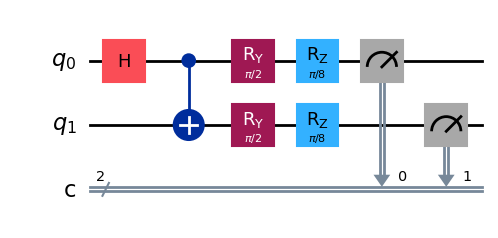

In [17]:
my_chsh_circuits[3].draw(output="mpl")

In [18]:
result_ideal = backend.run(my_chsh_circuits).result()

In [19]:
#tmp = list(zip(CHSH1_ideal, theta_vec))
#tmp.sort(reverse=True)

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

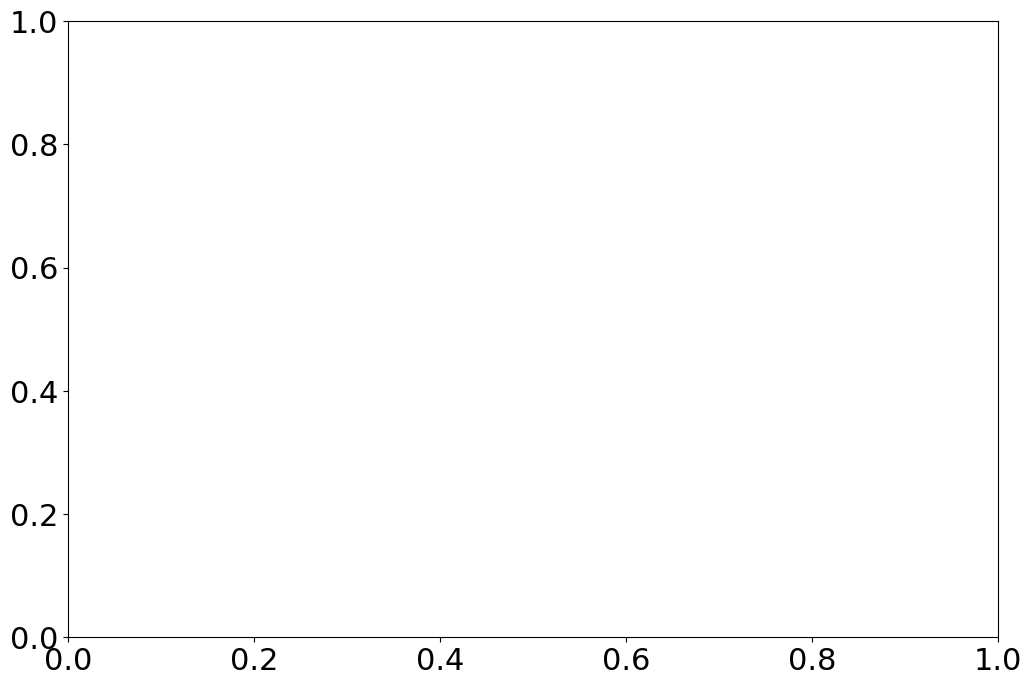

In [21]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,result_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,result_ideal,'o-',label = 'CHSH2 Noiseless')

plt.fill_between(theta_vec, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
#plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
#plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
for chsh, theta in tmp:
    plt.axvline(x=theta, color='g', linestyle='-.', ymin=2/3, ymax=np.sqrt(2)*2/3)
    plt.annotate(str(theta.round(2)),xy=(theta+0.05,chsh+0.05))
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

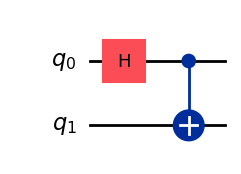

In [22]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
#chsh_circuit.ry(theta, 1)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [23]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
individual_phases = [[ph] for ph in phases]

In [24]:
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
observable1

SparsePauliOp(['ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])

In [230]:
from qiskit.circuit.library import RYGate
from qiskit.quantum_info import PauliList, Pauli

rya = RYGate(0).to_matrix()
ryA = RYGate(np.pi/4).to_matrix()
ryb = RYGate(np.pi/8).to_matrix()
ryB = RYGate(3*np.pi/8).to_matrix()

XX = SparsePauliOp.from_operator(np.kron(rya, ryb))
XZ = SparsePauliOp.from_operator(np.kron(rya, ryB))
ZX = SparsePauliOp.from_operator(-1*np.kron(ryA, ryb))
ZZ = SparsePauliOp.from_operator(np.kron(ryA, ryB))

obs2 = XX + XZ + ZX + ZZ
obs2

SparsePauliOp(['II', 'IY', 'II', 'IY', 'II', 'IY', 'YI', 'YY', 'II', 'IY', 'YI', 'YY'],
              coeffs=[ 0.98078528+0.j        , -0.        -0.19509032j,  0.83146961+0.j        ,
 -0.        -0.55557023j, -0.90612745+0.j        ,  0.        +0.18023996j,
  0.        +0.37533028j,  0.07465783-0.j        ,  0.76817776+0.j        ,
 -0.        -0.51327997j, -0.        -0.31818965j, -0.21260752+0.j        ])

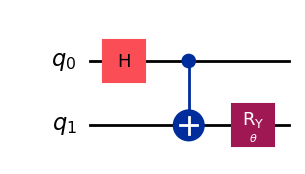

In [224]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [225]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_obs2 = obs2.apply_layout(layout=chsh_isa_circuit.layout)

In [ ]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(backend=backend)

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_obs2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

In [204]:
chsh1_est = job_result[0].data.evs[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In [25]:
def chsh_game(strategy):
    x, y = randint(0, 2), randint(0, 2)
    a, b = strategy(x, y)
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

In [43]:
def chsh_circuit(obs, is_param=False, theta=0):

    qc = QuantumCircuit(2,  2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()
    if is_param:
        qc.ry(theta, 0, label="$\\theta_Y$")

    # Alice
    if obs[0] == 'X':
        qc.ry(0, 0)
        #qc.rx(np.pi/2, 0)
        #qc.rz(np.pi/8, 0)
    else:
        qc.ry(np.pi/4,0)
        #qc.rx(np.pi/2, 0)
        #qc.rz(5*np.pi/8, 0)
    qc.measure(0, 0)

    # Bob
    if obs[1] == 'X':
        qc.ry(np.pi/8,1)
        #qc.rx(np.pi/2, 1)
        #qc.rz(np.pi/8, 1)
    else:
        qc.ry(3*np.pi/8,1)
        #qc.rx(np.pi/2, 1)
        #qc.rz(5*np.pi/8, 1)
    qc.measure(1, 1)

    return qc

In [49]:
sampler = Sampler()

def quantum_strategy(obs, is_param=False, theta=0):
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(obs, is_param=is_param, theta=theta), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    return bits

In [50]:
def chsh_count(strategy, n_shots, is_param=False, theta=0):
    res = {'XX':{},
           'XZ':{},
           'ZX':{},
           'ZZ':{}}

    for obs in res.keys():
        for _ in range(n_shots):
            bits = strategy(obs)
            if bits in res[obs]:
                res[obs][bits] += 1
            else:
                res[obs][bits] = 0

    chsh1 = 0
    chsh2 = 0
    for observable in res.keys():
        for bits in res[observable]:
            parity = (-1)**(int(bits[0])^int(bits[1]))
            if observable == 'ZX':
                chsh1 += parity*res[observable][bits]
                chsh2 -= parity*res[observable][bits]
            elif observable == 'XZ':
                chsh1 -= parity*res[observable][bits]
                chsh2 += parity*res[observable][bits]
            else:
                chsh1 += parity*res[observable][bits]
                chsh2 += parity*res[observable][bits]
    return abs(chsh1/n_shots), abs(chsh2/n_shots)

In [51]:
chsh1, chsh2 = chsh_count(quantum_strategy, 128, is_param=True, theta=np.pi)

In [52]:
number_of_phases = 20
theta_arr = np.linspace(0, 2 * np.pi, number_of_phases)

In [53]:
chsh1_arr = []
chsh2_arr = []

for theta in theta_arr:
    chsh1, chsh2 = chsh_count(quantum_strategy, 128, is_param=True, theta=theta)
    chsh1_arr.append(chsh1)
    chsh2_arr.append(chsh2)

Text(0, 0.5, 'CHSH witness')

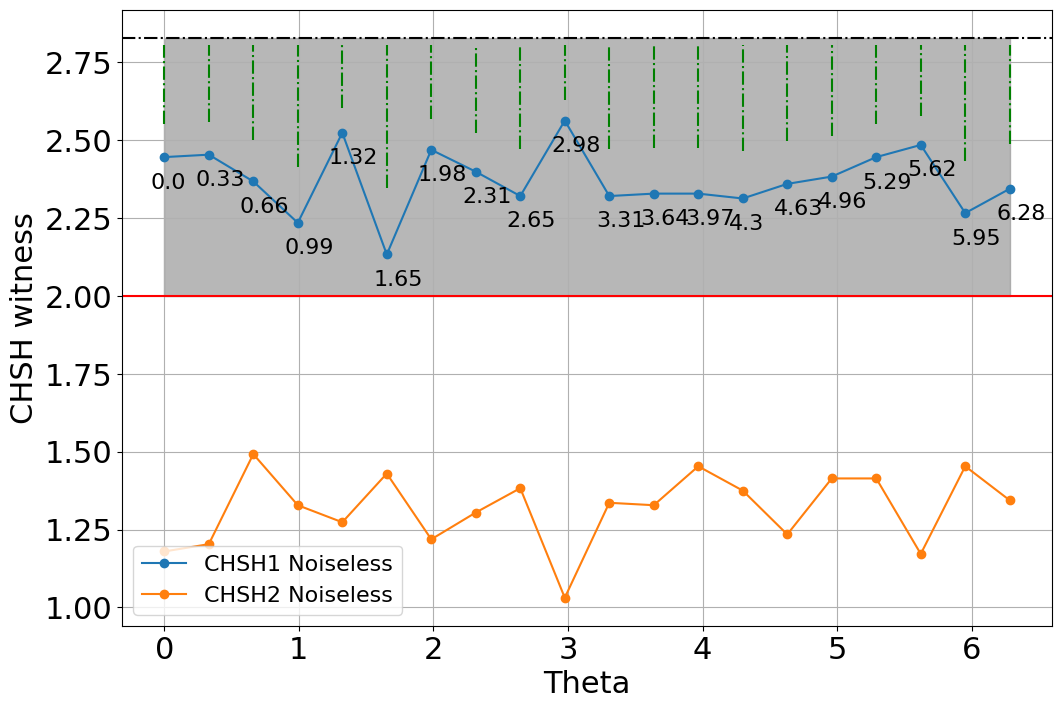

In [54]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_arr,chsh1_arr,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_arr,chsh2_arr,'o-',label = 'CHSH2 Noiseless')

plt.fill_between(theta_arr, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
#plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
#plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
for chsh, theta in zip(chsh1_arr,theta_arr):
    plt.axvline(x=theta, color='g', linestyle='-.', ymin=chsh/3, ymax=np.sqrt(2)*2/3)
    plt.annotate(str(theta.round(2)),xy=(theta-0.1,chsh-0.1))
plt.xlabel('Theta')
plt.ylabel('CHSH witness')